<a href="https://colab.research.google.com/github/cxz260/XzUtil/blob/main/TF_GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN(Generic Advisoral Network) for image generation(MNIST )Generator-Discriminator 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]

# Hyperparameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256
NOISE_DIM = 100
EPOCHS = 10 #50 gives good results

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the generator model
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Define the discriminator model
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


11490434/11490434 [==============================] - 0s 0us/step


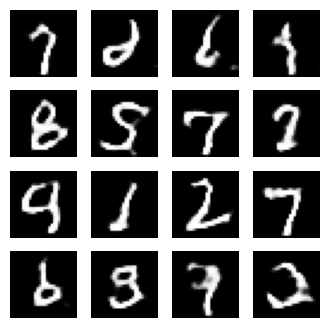

In [3]:
optimizer_gen = tf.keras.optimizers.Adam(1e-4)
optimizer_disc = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_gen.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    optimizer_disc.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train the GAN
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# Prepare test input for generating images
seed = tf.random.normal([16, NOISE_DIM])

# Train and generate images
train(train_dataset, EPOCHS)
generate_and_save_images(generator, EPOCHS, seed)
